In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential


In [2]:

from tensorflow import keras

data = keras.datasets.cifar10.load_data()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



(X_train, y_train), (X_test, y_test) = data
X_train = X_train / 255
X_test = X_test / 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# print(X_train.shape)


In [10]:
print(X_train.shape)
# test = [x for x in X_train]
# print(test[0].shape)

(40000, 32, 32, 3)


In [57]:
def create_rnp():
    rnp = Sequential(
        [Flatten(input_shape=[32, 32, 3])] + 
        [
            Dense(100,  activation="elu", kernel_initializer="he_normal") for i in range(20)
        ] +
        [Dense(10, activation="softmax")]
    )
    return rnp

rnp = create_rnp()
rnp.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.Nadam(learning_rate=1e-6))
rnp.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_248 (Dense)            (None, 100)               307300    
_________________________________________________________________
dense_249 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_250 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_251 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_252 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_253 (Dense)            (None, 100)             

In [54]:
## trying to find thhe best lr
K = keras.backend
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.rates.append(lr)
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, lr * self.factor)

expon_lr = ExponentialLearningRate(factor=1.005)
history = rnp.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), callbacks=[expon_lr])

import numpy as np
import matplotlib.pyplot as plt


grad_losses = [expon_lr.losses[i+1] - expon_lr.losses[i] for i in range(len(expon_lr.losses) - 1)]
grad_losses.append(grad_losses[-1])



1250/1250 [==============================] - 10s 6ms/step - loss: 3.2842 - accuracy: 0.1403 - val_loss: 2.2063 - val_accuracy: 0.2057


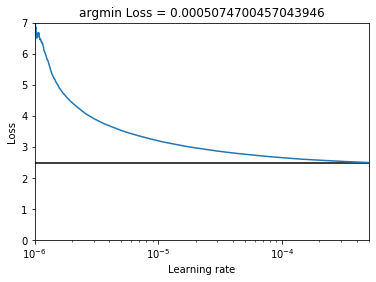

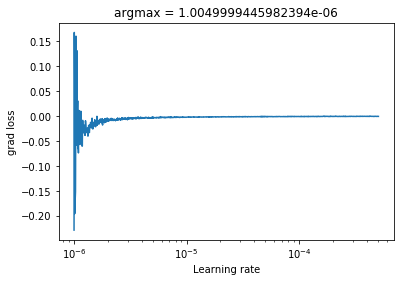

In [55]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, max(expon_lr.losses)])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title(f"argmin Loss = {expon_lr.rates[np.argmin(expon_lr.losses)]}")

plt.figure()
plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')

grad_losses = np.array(grad_losses)
grad_losses[np.abs(grad_losses) > 10] = 0
plt.plot(expon_lr.rates, grad_losses)
plt.xlabel("Learning rate")
plt.ylabel("grad loss")
plt.title(f"argmax = {expon_lr.rates[np.argmax(grad_losses)]}")
plt.show()

In [58]:
# Essayons de trouver le lr cette fois en comparant les courbes avec tensorboard

import os
import time
root = os.path.join(os.curdir, "my_logs")

def create_tensorboard_lr():
    # checkpoints = keras.callbacks.ModelCheckpoint("rnp.h5", save_best_only=True)
    for lr in [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]:
        early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

        def get_run_logdir():
            # run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
            run_id = time.strftime(f"lr={lr}")
            return os.path.join(root, run_id)

        tsboard = keras.callbacks.TensorBoard(get_run_logdir())

        rnp = create_rnp()
        rnp.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.Nadam(learning_rate=lr))

        history = rnp.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, tsboard])

create_tensorboard_lr()

Epoch 1/10
1250/1250 [==============================] - 10s 6ms/step - loss: 4.1799 - accuracy: 0.1104 - val_loss: 2.5283 - val_accuracy: 0.1312
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 2.3940 - accuracy: 0.1532 - val_loss: 2.2115 - val_accuracy: 0.1875
Epoch 3/10
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1833 - accuracy: 0.2028 - val_loss: 2.1220 - val_accuracy: 0.2234
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1000 - accuracy: 0.2361 - val_loss: 2.0647 - val_accuracy: 0.2451
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0498 - accuracy: 0.2577 - val_loss: 2.0239 - val_accuracy: 0.2632
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0083 - accuracy: 0.2749 - val_loss: 1.9919 - val_accuracy: 0.2796
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9719 - accuracy: 0.2894 - val_loss: 1.9659 - val_accuracy

In [60]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.


In [61]:
# now creating and retraining model
lr = 5e-5
rnp = create_rnp()
rnp.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.Nadam(learning_rate=lr))

def get_run_logdir():
            # run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
            run_id = time.strftime(f"lr={lr}")
            return os.path.join(root, run_id)

tsboard = keras.callbacks.TensorBoard(get_run_logdir())
checkpoints = keras.callbacks.ModelCheckpoint("rnp.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = rnp.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, tsboard])

# Environ 8s * 40 périodes


Epoch 1/100
1250/1250 [==============================] - 10s 6ms/step - loss: 2.2208 - accuracy: 0.2424 - val_loss: 1.7696 - val_accuracy: 0.3593
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7500 - accuracy: 0.3697 - val_loss: 1.7060 - val_accuracy: 0.3885
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.6405 - accuracy: 0.4091 - val_loss: 1.6340 - val_accuracy: 0.4111
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5895 - accuracy: 0.4327 - val_loss: 1.6221 - val_accuracy: 0.4174
Epoch 5/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5343 - accuracy: 0.4425 - val_loss: 1.5820 - val_accuracy: 0.4314
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5003 - accuracy: 0.4615 - val_loss: 1.5503 - val_accuracy: 0.4498
Epoch 7/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4635 - accuracy: 0.4711 - val_loss: 1.5432 - val_a

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid()
    plt.gca().set_ylim(0,1)
    plt.show()
plot_history(history)
# Accuracy_train ~ 66%
# Accuracy_tes ~ 45%

NameError: name 'history' is not defined

In [4]:
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
from tensorflow.keras.layers import BatchNormalization


rnp_batch = Sequential()
rnp_batch.add(Flatten(input_shape=[32, 32, 3]))
for i in range(20):
    rnp_batch.add(Dense(100,  activation="elu", kernel_initializer="he_normal"))
    rnp_batch.add(BatchNormalization())
rnp_batch.add(Dense(10, activation="softmax"))



In [5]:
# Pour trouver le lr, on refait la même manip avec tensorboard
lr = 5e-4
rnp_batch.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.Nadam(learning_rate=lr))


# tsboard = keras.callbacks.TensorBoard(get_run_logdir())
checkpoints = keras.callbacks.ModelCheckpoint("rnp_batch.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
batch_history = rnp_batch.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
1250/1250 [==============================] - 21s 11ms/step - loss: 2.1046 - accuracy: 0.2528 - val_loss: 1.8729 - val_accuracy: 0.3084
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7591 - accuracy: 0.3728 - val_loss: 1.9111 - val_accuracy: 0.3228
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6988 - accuracy: 0.3954 - val_loss: 1.6915 - val_accuracy: 0.4002
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6310 - accuracy: 0.4207 - val_loss: 1.6817 - val_accuracy: 0.4122
Epoch 5/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5818 - accuracy: 0.4402 - val_loss: 1.6981 - val_accuracy: 0.3835
Epoch 6/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5570 - accuracy: 0.4502 - val_loss: 1.7382 - val_accuracy: 0.3945
Epoch 7/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5158 - accuracy: 0.4615 - val_loss: 1

<Figure size 432x288 with 0 Axes>

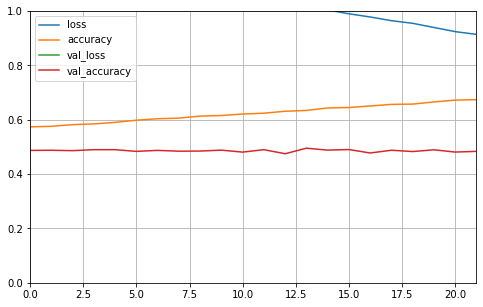

In [67]:
# On voit que ça a pris presque 2 fois moins d'époques pour avoir la même convergence, l'ajout de BN est donc un vrai plus
# L'entrainement prend moins de temps : 15s * 20 périodes = 300s, un moins qu'avant qui était de plus de 400s
plot_history(batch_history)
# Accuracy_train ~ 68%
# accuracy_val ~ 48%  donc un peu mieux que sans le BN, mais l'entrainement est bcp plus rapide

In [5]:
# Essayons SELU à la place de BN
def rnp_selu():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    for _ in range(20):
        model.add(keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

    model.add(keras.layers.Dense(10, activation="softmax"))

    optimizer = keras.optimizers.Nadam(lr=7e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

    run_index = 1 # increment every time you train the model
    run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

    X_means = X_train.mean(axis=0)
    X_stds = X_train.std(axis=0)
    X_train_scaled = (X_train - X_means) / X_stds
    X_valid_scaled = (X_val - X_means) / X_stds
    X_test_scaled = (X_test - X_means) / X_stds

    history = model.fit(X_train_scaled, y_train, epochs=100,
            validation_data=(X_valid_scaled, y_val),
            callbacks=callbacks)

    model = keras.models.load_model("my_cifar10_model.h5")
    model.evaluate(X_valid_scaled, y_val)
    return model, history

rnp_selu, history_selu = rnp_selu()

Epoch 1/100
1250/1250 [==============================] - 10s 6ms/step - loss: 2.0694 - accuracy: 0.2671 - val_loss: 1.7922 - val_accuracy: 0.3678
Epoch 2/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7274 - accuracy: 0.3843 - val_loss: 1.7115 - val_accuracy: 0.4008
Epoch 3/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6102 - accuracy: 0.4346 - val_loss: 1.6366 - val_accuracy: 0.4091
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5398 - accuracy: 0.4615 - val_loss: 1.6499 - val_accuracy: 0.4353
Epoch 5/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4908 - accuracy: 0.4771 - val_loss: 1.5456 - val_accuracy: 0.4556
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4286 - accuracy: 0.5004 - val_loss: 1.5568 - val_accuracy: 0.4606
Epoch 7/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3805 - accuracy: 0.5155 - val_loss: 1.5605 - val_a

<Figure size 432x288 with 0 Axes>

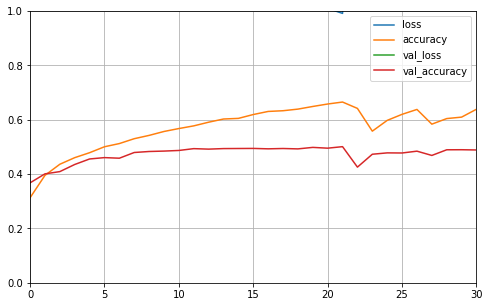

In [9]:
# accuracy: 0.6376, val_accuracy: 0.4887
# Un peu moins bien que le BN, et il prend plus d'époque : 30, ce qui reste mieux que sans BN tout court
plot_history(history_selu)

In [10]:
# Régulatisation avec AlphaDropout

def rnp_selu_dropout():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    for _ in range(20):
        model.add(keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))
    model.add(keras.layers.AlphaDropout(rate=0.1))
    model.add(keras.layers.Dense(10, activation="softmax"))

    optimizer = keras.optimizers.Nadam(lr=7e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_dropout_model.h5", save_best_only=True)

    run_index = 1 # increment every time you train the model
    run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_dropout_{:03d}".format(run_index))
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

    X_means = X_train.mean(axis=0)
    X_stds = X_train.std(axis=0)
    X_train_scaled = (X_train - X_means) / X_stds
    X_valid_scaled = (X_val - X_means) / X_stds
    X_test_scaled = (X_test - X_means) / X_stds

    history = model.fit(X_train_scaled, y_train, epochs=100,
            validation_data=(X_valid_scaled, y_val),
            callbacks=callbacks)

    model = keras.models.load_model("my_cifar10_dropout_model.h5")
    model.evaluate(X_valid_scaled, y_val)
    return model, history

rnp_selu_dp, history_selu_dp = rnp_selu_dropout()

Epoch 1/100
1250/1250 [==============================] - 10s 6ms/step - loss: 2.0737 - accuracy: 0.2716 - val_loss: 1.8359 - val_accuracy: 0.3593
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7328 - accuracy: 0.3848 - val_loss: 1.7612 - val_accuracy: 0.3893
Epoch 3/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6376 - accuracy: 0.4206 - val_loss: 1.6398 - val_accuracy: 0.4253
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5658 - accuracy: 0.4498 - val_loss: 1.5858 - val_accuracy: 0.4515
Epoch 5/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5162 - accuracy: 0.4662 - val_loss: 1.5994 - val_accuracy: 0.4412
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4567 - accuracy: 0.4894 - val_loss: 1.5853 - val_accuracy: 0.4622
Epoch 7/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4199 - accuracy: 0.5076 - val_loss: 1.7112 - val_a

<Figure size 432x288 with 0 Axes>

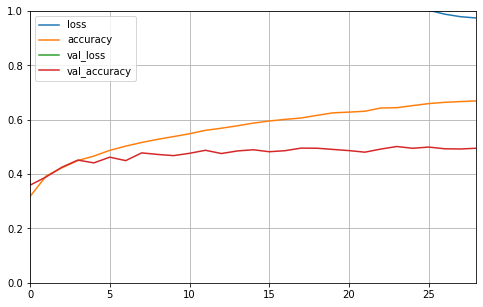

In [12]:
# accuracy: 0.6720 - val_loss: 1.7528 - val_accuracy: 0.4951 
# L'entrainement a pris plus ou moins de temps, mais il aurait dû prendre plus de temps non ? car ça devrait converger moins rapidement
# Par contre l'accuracy de validation est un peu meilleur. On a bien ici un effet régularisateur même s'il est minime ?
# Il faudrait essayer d'autre valeurs de lr, et de dropout_rate ? 
plot_history(history_selu_dp)

In [18]:
# MC dropout
import numpy as np
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [21]:
from sklearn.metrics import accuracy_score

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in rnp_selu_dp.layers
])

#Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)


# Now let's make predictions for all the instances in the validation set, and compute the accuracy:

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = accuracy_score(y_pred, y_val)
accuracy # A peu près la même précision que SELU-dropout, en un peu moins bon ? Ce n'est pas censé être un peu meilleur

0.4734

In [29]:
# utilisons un schedule de learning_rate
from tensorflow.keras.layers import Dense, BatchNormalization

def create_rnp_bn():
    rnp_batch = Sequential()
    rnp_batch.add(Flatten(input_shape=[32, 32, 3]))
    for i in range(20):
        rnp_batch.add(Dense(100,  activation="elu", kernel_initializer="he_normal"))
        rnp_batch.add(BatchNormalization())
    rnp_batch.add(Dense(10, activation="softmax"))
    return rnp_batch

rnp_batch = create_rnp_bn()
# Pour trouver le lr, on refait la même manip avec tensorboard
lr = 5e-4 * 10

# Ca prend un peu plus de temps à train. Le temps de train de chaque époque augmente car mettre à jour le learning_rate avec une fonction exponentielle prend du temps.
def exponential_decay_fn(s = 20, decrease_every_s = 0.1):
    def exponential_decay(epoch, lr):
        return lr * decrease_every_s ** (1/s)
    return exponential_decay

exponential_decay = exponential_decay_fn()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)
rnp_batch.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.Nadam(learning_rate=lr))


early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
batch_history = rnp_batch.fit(X_train, y_train, epochs=100, validation_data=(X_valid_scaled, y_val), callbacks=[lr_scheduler, early_stopping])
plot_history(batch_history)

Epoch 1/100
1250/1250 [==============================] - 20s 11ms/step - loss: 2.1024 - accuracy: 0.2453 - val_loss: 2.1805 - val_accuracy: 0.2803
Epoch 2/100
 923/1250 [=====================>........] - ETA: 3s - loss: 1.8470 - accuracy: 0.3333

KeyboardInterrupt: 

In [30]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [33]:
batch_size = 32
K = keras.backend
n_epochs = 100
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)

def create_rnp_bn():
    rnp_batch = Sequential()
    rnp_batch.add(Flatten(input_shape=[32, 32, 3]))
    for i in range(20):
        rnp_batch.add(Dense(100,  activation="elu", kernel_initializer="he_normal"))
        rnp_batch.add(BatchNormalization())
    rnp_batch.add(Dense(10, activation="softmax"))
    return rnp_batch

rnp_batch = create_rnp_bn()
lr = 5e-4
rnp_batch.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.Nadam(learning_rate=lr))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = rnp_batch.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_val),
                    callbacks=[onecycle, early_stopping])

plot_history(batch_history)

                    

Epoch 1/100
1250/1250 [==============================] - 20s 12ms/step - loss: 2.0937 - accuracy: 0.2503 - val_loss: 2.0462 - val_accuracy: 0.3221
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.8069 - accuracy: 0.3501 - val_loss: 1.7927 - val_accuracy: 0.3785
Epoch 3/100
1250/1250 [==============================] - 14s 12ms/step - loss: 1.7476 - accuracy: 0.3745 - val_loss: 2.5733 - val_accuracy: 0.2842
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7078 - accuracy: 0.3913 - val_loss: 2.5071 - val_accuracy: 0.2893
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6597 - accuracy: 0.4133 - val_loss: 2.3974 - val_accuracy: 0.3174
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6249 - accuracy: 0.4223 - val_loss: 2.3772 - val_accuracy: 0.2950
Epoch 7/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5729 - accuracy: 0.4442 - val_loss: 2

KeyboardInterrupt: 